# 2022 DL_HW 3-2 LunarLander-v2

## 助教範例 Code

In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender==1.0.8 
!pip install box2d-py
import gym
from colabgymrender.recorder import Recorder

env = gym.make("LunarLander-v2")
directory = './video'
env = Recorder(env, directory)

observation = env.reset()

terminal = False
while not terminal:
  action = env.action_space.sample()
  observation, reward, terminal, info = env.step(action)
env.play()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colabgymrender: filename=colabgymrender-1.0.8-py3-none-any.whl size=2511 sha256=715bf46f17ec90025998690728691c419f74e9a38cb9b53965eb2d0ff7d2a86e
  Stored in directory: /root/.cache/pip/wheels/ff/52/c0/233f92882799786e8d7ff69c7461e32afe24a66fd2cee0494f
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 8.0 MB/s 
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3219456/45929032 bytes (7.0%)7446528/45929032 bytes (16.2%)11599872/45929032 bytes (25.3%)

 99%|█████████▉| 100/101 [00:00<00:00, 372.56it/s]


## Package

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## 3-2.1. Deep Q-Networks (DQN)

### (a) Please follow the algorithm shown below and use ϵ-greedy policy to implement the DQN. (show the result movie)

#### Model

In [ ]:
class DQN(nn.Module):
  def __init__(self, n_state, hidden_dim, n_action, lr):
    super(DQN, self).__init__()

    self.n_state = n_state
    self.hidden_dim = hidden_dim
    self.n_action = n_action

    self.fc1 = nn.Linear(self.n_state, self.hidden_dim)
    self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.fc3 = nn.Linear(self.hidden_dim, self.n_action)
    self.relu = nn.ReLU()

    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.criterion = nn.MSELoss()
    
  def forward(self, state):
    x = self.relu(self.fc1(state))
    x = self.relu(self.fc2(x))
    action = self.fc3(x)
    return action



#### Agent

In [ ]:
class Agent():
  def __init__(self, gamma, epsilon, lr, batch_size, n_state, n_action, hidden_dim, epsilon_desc, epsilon_min, device, max_memory_size=10000):
    self.gamma = gamma
    self.epsilon = epsilon
    self.lr = lr
    self.n_state = n_state
    self.batch_size = batch_size
    self.n_action = n_action
    self.hidden_dim = hidden_dim
    self.mem_size = max_memory_size # default = 10,000 
    self.mem_counter = 0
    self.epsilon_desc = epsilon_desc
    self.epsilon_min = epsilon_min
    self.device = device

    self.qeval_model = DQN(n_state, hidden_dim, n_action, lr).to(self.device)
    # self.target_model = DQN(n_state, hidden_dim, n_action, lr).to(self.device)

    self.state_mem = np.zeros((self.mem_size, self.n_state), dtype=np.float32)
    self.newstate_mem = np.zeros((self.mem_size, self.n_state), dtype=np.float32)
    self.action_mem = np.zeros(self.mem_size, dtype=np.int32)
    self.reward_mem = np.zeros(self.mem_size, dtype=np.float32)
    self.terminal_mem = np.zeros(self.mem_size, dtype=np.bool)
  
  # 把 data 裝進 buffer
  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_counter % self.mem_size
    self.state_mem[index] = state
    self.action_mem[index] = action
    self.reward_mem[index] = reward
    self.newstate_mem[index] = state_
    self.terminal_mem[index] = done
    self.mem_counter += 1
  
  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
      state = torch.tensor([observation]).to(self.device)
      acts_value = self.qeval_model.forward(state)
      action = torch.argmax(acts_value).item()
    else:
      action = np.random.choice(self.n_action)

    return action

  def choose_action_with_advantage(self, observation):
    state = torch.tensor([observation]).to(self.device)
    acts_value = self.qeval_model.forward(state)
    return acts_value

  def learn(self):
    # DQN with target 
    # if self.mem_counter % TARGET_UPDATE == 0: # 每 TARGET_UPDATE 次複製 qeval_model 到 target_model

    # Soft Update 
      # for target_param, local_param in zip(self.target_model.parameters(), self.qeval_model.parameters()):
      #       tau = 1e-3
      #       target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

      # self.target_model.load_state_dict(self.qeval_model.state_dict())

    if self.mem_counter < self.batch_size:
      return

    if self.mem_counter % TARGET_UPDATE == 0: # 每 TARGET_UPDATE 次 update qeval_model
      self.qeval_model.optimizer.zero_grad() # 清空 qeval_model 的 gradient 
      
      # get batch data from memory buffer
      max_mem = min(self.mem_counter, self.mem_size)
      batch = np.random.choice(max_mem, self.batch_size, replace=False) # 0 ~ (mem_size-1) 抽 batch_size 個不重複亂數
      batch_index = np.arange(self.batch_size, dtype=np.int32) # batch_index = 0 ~ (batch_size-1)
      state_batch = torch.tensor(self.state_mem[batch]).to(self.device)
      action_batch = self.action_mem[batch]
      reward_batch = torch.tensor(self.reward_mem[batch]).to(self.device)
      newstate_batch = torch.tensor(self.newstate_mem[batch]).to(self.device)
      terminal_batch = torch.tensor(self.terminal_mem[batch]).to(self.device)

      
      # Regression
      q_eval = self.qeval_model.forward(state_batch)[batch_index, action_batch] 
      # q_next = self.target_model.forward(newstate_batch).detach()
      q_next = self.qeval_model.forward(newstate_batch)
      q_next[terminal_batch] = 0.0
      q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]
      
      # q_target[terminal_batch] = 0.0

      loss = self.qeval_model.criterion(q_target, q_eval).to(self.device)
      loss.backward()
      self.qeval_model.optimizer.step()

      self.epsilon = self.epsilon-self.epsilon_desc if self.epsilon > self.epsilon_min else self.epsilon_min
  

#### Hyperparameter

In [ ]:
NUM_EPISODE = 350
EPSILON = 1.0   # greedy policy
EPSILON_DESC = 5e-4
EPSILON_MIN = 0.01
GAMMA = 0.99   # discount rate
LEARNING_RATE = 0.001
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
HIDDEN_SIZE = 256
TARGET_UPDATE = 1   # model update frequency

env = gym.make("LunarLander-v2")

N_STATE = env.observation_space.shape[0]
N_ACTION = env.action_space.n

dqn_agent = Agent(GAMMA, EPSILON, LEARNING_RATE, BATCH_SIZE, N_STATE, N_ACTION, HIDDEN_SIZE, EPSILON_DESC, EPSILON_MIN, device, MEMORY_CAPACITY)

#### Training

In [ ]:
rewardList = [] 
averRewardList = [] # 平均 reward
averRewardList_part = [] # 最近 part 次的平均 reward
part = -100 # ex 最近 100 次的平均 reward

for episode in range(NUM_EPISODE): # 玩 NUM_EPISODE 次

  if episode > NUM_EPISODE-3: # 蒐集最後 3 支影片
    env = gym.make("LunarLander-v2")
    directory = './video_DQN'
    env = Recorder(env, directory)
    
  observation = env.reset() # 初始化遊戲場景
  done = False
  totalReward = 0

  while not done: 

    action = dqn_agent.choose_action(observation) # 根據遊戲場景決定 action (use ϵ-greedy policy)
    observation_, reward, done, _= env.step(action) # 使用該 action 得到的 data
    dqn_agent.store_transition(observation, action, reward, observation_, done)
    dqn_agent.learn()
    totalReward += reward
    observation = observation_

  if episode > NUM_EPISODE-3: # 播放最後 3 支影片 
    env.play()

  # save trainging info.
  rewardList.append(totalReward)
  averReward_part = np.mean(rewardList[part:])
  averReward = np.sum(rewardList) / (episode+1)
  averRewardList.append(averReward)
  averRewardList_part.append(averReward_part)

  print('Episode {}, epsilon {}:\t reward {},\t averReward_{} {},\t avgReward {}'.format(episode+1, round(dqn_agent.epsilon, 4), totalReward, abs(part),averReward_part, averReward))
  



Episode 1, epsilon 0.977:	 reward -61.60290122805311,	 averReward_100 -61.60290122805311,	 avgReward -61.60290122805311
Episode 2, epsilon 0.9355:	 reward -184.20232593134705,	 averReward_100 -122.90261357970007,	 avgReward -122.90261357970007
Episode 3, epsilon 0.889:	 reward -109.22996579944403,	 averReward_100 -118.34506431961472,	 avgReward -118.34506431961472
Episode 4, epsilon 0.8405:	 reward -109.51762448771602,	 averReward_100 -116.13820436164005,	 avgReward -116.13820436164005
Episode 5, epsilon 0.7865:	 reward -248.4021693933684,	 averReward_100 -142.59099736798572,	 avgReward -142.59099736798572
Episode 6, epsilon 0.747:	 reward -92.36861787811117,	 averReward_100 -134.22060078633996,	 avgReward -134.22060078633996
Episode 7, epsilon 0.6815:	 reward -90.0431442538353,	 averReward_100 -127.90953556741071,	 avgReward -127.90953556741071
Episode 8, epsilon 0.6235:	 reward -97.91831908528289,	 averReward_100 -124.16063350714474,	 avgReward -124.16063350714474
Episode 9, epsilon 

100%|█████████▉| 245/246 [00:00<00:00, 379.91it/s]


Episode 349, epsilon 0.01:	 reward 227.52918413795595,	 averReward_100 125.0475941045711,	 avgReward 35.11439754430389


100%|█████████▉| 256/257 [00:00<00:00, 383.74it/s]


Episode 350, epsilon 0.01:	 reward 243.91063773507173,	 averReward_100 128.1490299151872,	 avgReward 35.710958230563236


#### Learning Curve

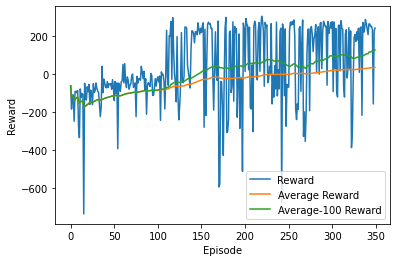

In [ ]:
x = list(range(len(rewardList)))
_ = plt.plot(np.array(x), np.array(rewardList), label='Reward')
_ = plt.plot(x, averRewardList, label='Average Reward')
_ = plt.plot(x, averRewardList_part, label='Average-100 Reward')
_ = plt.xlabel('Episode') 
_ = plt.ylabel('Reward') 
_ = plt.legend(loc=4, prop={'size': 10}) 


#### Result Movie

In [ ]:
env.play()

100%|█████████▉| 256/257 [00:00<00:00, 394.79it/s]


### (b) Please choose some hyper-parameters about collecting and using trajectories and analyze how these hyper-parameters affect the training result or training time.

#### Discussion

嘗試每 5 個 step 才更新一次 Q model (a 小題是使用 1 個 step 更新一次 Q model)， 然後固定其他超參數， 看看能不能在加速訓練的同時，還能保持 Reward 的上升。

#### Hyperparameter

In [ ]:
NUM_EPISODE = 350
EPSILON = 1.0   # greedy policy
EPSILON_DESC = 5e-4
EPSILON_MIN = 0.01
GAMMA = 0.99   # discount rate
LEARNING_RATE = 0.001
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
HIDDEN_SIZE = 256
TARGET_UPDATE = 5   # model update frequency

env = gym.make("LunarLander-v2")

N_STATE = env.observation_space.shape[0]
N_ACTION = env.action_space.n

dqn2_agent = Agent(GAMMA, EPSILON, LEARNING_RATE, BATCH_SIZE, N_STATE, N_ACTION, HIDDEN_SIZE, EPSILON_DESC, EPSILON_MIN, device, MEMORY_CAPACITY)

#### Training

In [ ]:
rewardList = [] 
averRewardList = [] # 平均 reward
averRewardList_part = [] # 最近 part 次的平均 reward
part = -100 # ex 最近 100 次的平均 reward

for episode in range(NUM_EPISODE): # 玩 NUM_EPISODE 次

  if episode > NUM_EPISODE-3: # 蒐集最後 3 支影片
    env = gym.make("LunarLander-v2")
    directory = './video_DQN'
    env = Recorder(env, directory)
    
  observation = env.reset() # 初始化遊戲場景
  done = False
  totalReward = 0

  while not done:

    action = dqn2_agent.choose_action(observation) # 根據遊戲場景決定 action (use ϵ-greedy policy)
    observation_, reward, done, _= env.step(action) # 使用該 action 得到的 data
    dqn2_agent.store_transition(observation, action, reward, observation_, done)
    dqn2_agent.learn()
    totalReward += reward
    observation = observation_

  if episode > NUM_EPISODE-3: # 播放最後 3 支影片 
    env.play()

  # save trainging info.
  rewardList.append(totalReward)
  averReward_part = np.mean(rewardList[part:])
  averReward = np.sum(rewardList) / (episode+1)
  averRewardList.append(averReward)
  averRewardList_part.append(averReward_part)

  print('Episode {}, epsilon {}:\t reward {},\t averReward_{} {},\t avgReward {}'.format(episode+1, round(dqn_agent.epsilon, 4), totalReward, abs(part),averReward_part, averReward))

Episode 1, epsilon 0.01:	 reward -100.85170936299035,	 averReward_100 -100.85170936299035,	 avgReward -100.85170936299035
Episode 2, epsilon 0.01:	 reward -150.71051690105946,	 averReward_100 -125.7811131320249,	 avgReward -125.7811131320249
Episode 3, epsilon 0.01:	 reward -170.72312640451884,	 averReward_100 -140.76178422285622,	 avgReward -140.76178422285622
Episode 4, epsilon 0.01:	 reward -87.23869071013537,	 averReward_100 -127.381010844676,	 avgReward -127.381010844676
Episode 5, epsilon 0.01:	 reward -146.86348797069613,	 averReward_100 -131.27750626988,	 avgReward -131.27750626988
Episode 6, epsilon 0.01:	 reward -196.1303261543498,	 averReward_100 -142.0863095839583,	 avgReward -142.0863095839583
Episode 7, epsilon 0.01:	 reward -208.45312751072646,	 averReward_100 -151.5672835734966,	 avgReward -151.5672835734966
Episode 8, epsilon 0.01:	 reward -114.32001147111131,	 averReward_100 -146.91137456069845,	 avgReward -146.91137456069845
Episode 9, epsilon 0.01:	 reward -108.5629

100%|█████████▉| 841/842 [00:02<00:00, 402.64it/s]


Episode 349, epsilon 0.01:	 reward 141.7150556728733,	 averReward_100 -47.2902084153823,	 avgReward -90.77762750296354


 99%|█████████▉| 146/147 [00:00<00:00, 332.37it/s]


Episode 350, epsilon 0.01:	 reward -257.6454736736342,	 averReward_100 -51.97639315161948,	 avgReward -91.25439277773688


#### Learning Curve

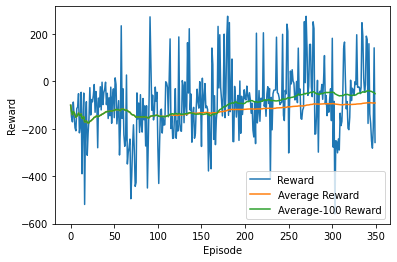

In [ ]:
x = list(range(len(rewardList)))
_ = plt.plot(np.array(x), np.array(rewardList), label='Reward')
_ = plt.plot(x, averRewardList, label='Average Reward')
_ = plt.plot(x, averRewardList_part, label='Average-100 Reward')
_ = plt.xlabel('Episode') 
_ = plt.ylabel('Reward') 
_ = plt.legend(loc=4, prop={'size': 10}) 

#### Conclusion

由上圖發現， 5 steps 更新一次 Q model， 雖然訓練時間短， 但 model 訓練不太起來， reward 無法穩定上升。

## 3-2.2. PPO in actor-critic (Bonus)

### (a) Please use stochastic policy (categorical distribution) and trained DQN model from previous part to train an agent in LunarLander-v2 environment.(show the result movie)

#### Model

In [ ]:
class PPOnetwork(nn.Module):
  def __init__(self, n_state, hidden_dim, n_action, lr):
    super(PPOnetwork, self).__init__()

    self.n_state = n_state
    self.hidden_dim = hidden_dim
    self.n_action = n_action
 
    self.fc1 = nn.Linear(self.n_state, self.hidden_dim)
    self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.fc3 = nn.Linear(self.hidden_dim, self.n_action)
    self.tanh = nn.Tanh()
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    
  def forward(self, state):
    x = self.tanh(self.fc1(state))
    x = self.tanh(self.fc2(x))
    action = self.fc3(x)
    return F.softmax(action, dim=-1)

#### Agent

In [ ]:
from torch.distributions import Categorical

class PPOagent():
      def __init__(self, device, batch_size, n_state, n_action, hidden_dim, lr, max_memory_size=10000, update_step_num=10):
          self.device = device
          self.n_state = n_state
          self.n_action = n_action
          self.hidden_dim = hidden_dim
          self.batch_size = batch_size
          self.PPOmodel = PPOnetwork(n_state, hidden_dim, n_action, lr).to(self.device)
          self.PPOmodel_old = PPOnetwork(n_state, hidden_dim, n_action, lr).to(self.device)
          self.PPOmodel_old.load_state_dict(self.PPOmodel.state_dict())
          self.lr = lr
          self.mem_counter = 0
          self.mem_size = max_memory_size
          self.update_step_num = update_step_num

          self.state_mem = np.zeros((self.mem_size, self.n_state), dtype=np.float32)
          self.newstate_mem = np.zeros((self.mem_size, self.n_state), dtype=np.float32)
          self.action_mem = np.zeros(self.mem_size, dtype=np.int32)
          self.reward_mem = np.zeros(self.mem_size, dtype=np.float32)
          self.terminal_mem = np.zeros(self.mem_size, dtype=np.bool)
          self.log_prob_mem = np.zeros(self.mem_size, dtype=np.float32)
          self.advantage_mem = np.zeros(self.mem_size, dtype=np.float32)

      def store_transition(self, state, action, reward, state_, done):
          index = self.mem_counter % self.mem_size
          self.state_mem[index] = state
          self.action_mem[index] = action
          self.reward_mem[index] = reward
          self.newstate_mem[index] = state_
          self.terminal_mem[index] = done
          self.mem_counter += 1


      def choose_action(self, observation):
          state = torch.tensor([observation]).to(self.device)
          action_prob = self.PPOmodel.forward(state)
          action_dist = Categorical(action_prob)
          action = action_dist.sample() # 依照 action_dist prob. 選 action
          log_prob = action_dist.log_prob(action).to(self.device)

          # 儲存 log prob. 至 buffer
          index = self.mem_counter % self.mem_size
          self.log_prob_mem[index] = log_prob
          
          # 計算 Advantage 儲存至 buffer
          q_value = dqn_agent.choose_action_with_advantage(observation)
          self.advantage_mem[index] = q_value[0][action.item()] - torch.mean(q_value[0])

          return action.item(), action_prob
          

      def learn(self):

          if self.mem_counter < self.batch_size:
            return

          if self.mem_counter % self.update_step_num == 0:

            self.PPOmodel.optimizer.zero_grad()
            # get batch data from memory buffer
            max_mem = min(self.mem_counter, self.mem_size)

            batch = np.random.choice(max_mem, self.batch_size, replace=False) # 0 ~ (mem_size-1) 抽 batch_size 個不重複亂數
            batch_index = np.arange(self.batch_size, dtype=np.int32) # batch_index = 0 ~ (batch_size-1)
            state_batch = torch.tensor(self.state_mem[batch]).to(self.device)
            action_batch = self.action_mem[batch]
            reward_batch = torch.tensor(self.reward_mem[batch]).to(self.device)
            newstate_batch = torch.tensor(self.newstate_mem[batch]).to(self.device)
            terminal_batch = torch.tensor(self.terminal_mem[batch]).to(self.device)
            advantage_batch = torch.tensor(self.advantage_mem[batch]).to(self.device)
            log_prob_batch = torch.tensor(self.log_prob_mem[batch]).to(self.device)

            action_prob = self.PPOmodel.forward(state_batch)[batch_index, action_batch]
            action_prob = torch.log(action_prob)

            IS = torch.exp(action_prob-log_prob_batch)
            beta = 0.2

            PPO_loss_item1 = IS*advantage_batch
            PPO_loss_item2 = torch.clamp(IS, 1-beta, 1+beta)*advantage_batch
            PPO_loss = -torch.mean(torch.minimum(PPO_loss_item1,PPO_loss_item2))

            loss = PPO_loss.to(self.device)
            loss.backward()
            self.PPOmodel.optimizer.step() 

#### Hyperparameter

In [ ]:
NUM_EPISODE = 300
LEARNING_RATE = 0.001
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
HIDDEN_SIZE = 256
UPDATE_STEP_NUM = 10 # model update frequency

env = gym.make("LunarLander-v2")

N_STATE = env.observation_space.shape[0]
N_ACTION = env.action_space.n

PPO_agent = PPOagent(device, BATCH_SIZE, N_STATE, N_ACTION, HIDDEN_SIZE, LEARNING_RATE, MEMORY_CAPACITY, UPDATE_STEP_NUM)

#### Training

In [ ]:
rewardList = [] 
averRewardList = [] # 平均 reward
averRewardList_part = [] # 最近 part 次的平均 reward
part = -100 # ex 最近 100 次的平均 reward

for episode in range(NUM_EPISODE): # 玩 NUM_EPISODE 次

  if episode > NUM_EPISODE-3: # 蒐集最後 3 支影片
    env = gym.make("LunarLander-v2")
    directory = './video_PPO'
    env = Recorder(env, directory)
    
  observation = env.reset() # 初始化遊戲場景
  done = False
  totalReward = 0
  
  while not done: 

    action, _ = PPO_agent.choose_action(observation) # 根據遊戲場景決定 action (use stochastic policy)
    observation_, reward, done, _= env.step(action) # 使用該 action 得到的 data
    PPO_agent.store_transition(observation, action, reward, observation_, done)
    PPO_agent.learn()
    totalReward += reward
    observation = observation_

  if episode > NUM_EPISODE-3: # 撥放最後 3 支影片 
    env.play()

  # save trainging info.
  rewardList.append(totalReward)
  averReward_part = np.mean(rewardList[part:])
  averReward = np.sum(rewardList) / (episode+1)
  averRewardList.append(averReward)
  averRewardList_part.append(averReward_part)

  print('Episode {},\t reward {},\t averReward_{} {},\t avgReward {}'.format(episode+1, totalReward, abs(part), averReward_part, averReward))

Episode 1,	 reward -114.95606439423312,	 averReward_100 -114.95606439423312,	 avgReward -114.95606439423312
Episode 2,	 reward -461.7704572624855,	 averReward_100 -288.36326082835933,	 avgReward -288.36326082835933
Episode 3,	 reward -361.16489497920384,	 averReward_100 -312.63047221197417,	 avgReward -312.63047221197417
Episode 4,	 reward -428.525867468321,	 averReward_100 -341.60432102606086,	 avgReward -341.60432102606086
Episode 5,	 reward -421.32290199333676,	 averReward_100 -357.548037219516,	 avgReward -357.548037219516
Episode 6,	 reward -338.733834805265,	 averReward_100 -354.41233681714084,	 avgReward -354.41233681714084
Episode 7,	 reward -459.0452273514989,	 averReward_100 -369.3598926077634,	 avgReward -369.3598926077634
Episode 8,	 reward -381.06291361663256,	 averReward_100 -370.8227702338721,	 avgReward -370.8227702338721
Episode 9,	 reward -336.8204651441342,	 averReward_100 -367.0447363350124,	 avgReward -367.0447363350124
Episode 10,	 reward -214.5743018939602,	 aver

100%|█████████▉| 319/320 [00:00<00:00, 388.66it/s]


Episode 299,	 reward 259.7236857020289,	 averReward_100 144.82477054513814,	 avgReward 35.79445883601227


100%|█████████▉| 311/312 [00:00<00:00, 386.80it/s]


Episode 300,	 reward 250.69940207949523,	 averReward_100 144.7113197868573,	 avgReward 36.51080864682388


#### Learning Curve

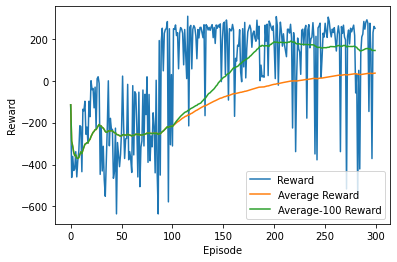

In [ ]:
x = list(range(len(rewardList)))
_ = plt.plot(np.array(x), np.array(rewardList), label='Reward')
_ = plt.plot(x, averRewardList, label='Average Reward')
_ = plt.plot(x, averRewardList_part, label='Average-100 Reward')
_ = plt.xlabel('Episode') 
_ = plt.ylabel('Reward') 
_ = plt.legend(loc=4, prop={'size': 10}) 

#### Result Movie

In [ ]:
env.play()

100%|█████████▉| 264/265 [00:00<00:00, 392.62it/s]


### (b) After training, please draw the probability-step picture for each action during testing and show below the result movie.

#### Testing

In [ ]:
env = gym.make("LunarLander-v2")
directory = './video_PPO_test'
env = Recorder(env, directory)
observation = env.reset() 
done = False
totalReward = 0
action_sample_prob_list = []

while not done: 

  action, action_sample_prob = PPO_agent.choose_action(observation)
  action_sample_prob_list.append(action_sample_prob.tolist()[0])
  observation_, reward, done, _= env.step(action) 
  totalReward += reward
  observation = observation_

print(totalReward)
probability_step_picture_data = map(list, zip(*action_sample_prob_list))
probability_step_picture_data = list(probability_step_picture_data)

267.8317270908618


#### Result Movie

In [ ]:
env.play()

100%|█████████▉| 314/315 [00:00<00:00, 392.19it/s]


#### Plot testing move probability

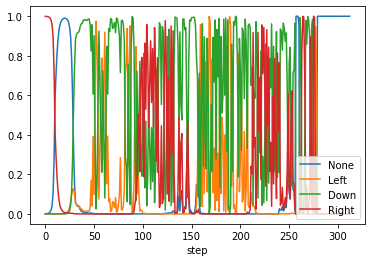

In [ ]:
x = list(range(len(probability_step_picture_data[0])))
_ = plt.plot(x, probability_step_picture_data[0], label='None')
_ = plt.plot(x, probability_step_picture_data[1], label='Left')
_ = plt.plot(x, probability_step_picture_data[2], label='Down')
_ = plt.plot(x, probability_step_picture_data[3], label='Right')
_ = plt.xlabel('step') 
_ = plt.legend(loc=4)